# Initial Setup

In [2]:
import pandas as pd
import os
import numpy as np
import datetime
#import duckdb
from plotnine import *
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 20)

In [3]:
filename = os.getcwd() + "/train.csv"
data = pd.read_csv(filename)

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
target = 'Survived'
numeric_cols = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_cols = ['Pclass', 'Sex', 'Embarked']

# Helper functions for model diagnostics

In [6]:
from sklearn import metrics

def model_diagnostics(y_test, preds, preds_binary):
    dict_scores = {}

    dict_scores['accuracy'] = metrics.accuracy_score(y_test, preds_binary)
    dict_scores['average_precision'] = metrics.average_precision_score(y_true = y_test, y_score = preds)
    dict_scores['f1_score'] = metrics.f1_score(y_test, preds_binary)

    dict_scores

    # Confusion matrix
    cm = metrics.confusion_matrix(y_test, preds_binary)
    cm_display = metrics.ConfusionMatrixDisplay(cm)

    # Precision recall curve
    x = metrics.precision_recall_curve(y_test, preds)

    df_pr_curve = pd.DataFrame()

    df_pr_curve['precision'] = x[0][:-1]
    df_pr_curve['recall'] = x[1][:-1]
    df_pr_curve['threshold'] = x[2]

    auprc = metrics.auc(df_pr_curve['recall'], df_pr_curve['precision'])
    auprc_noskill = np.mean(y_test)
    auprc_text = f"Area under PR curve: {round(auprc, 3)}"

    pr_plot = (
        ggplot(df_pr_curve, aes(x = 'recall', y = 'precision')) 
        + geom_line(size = 1, color = 'orange')
        + geom_hline(aes(yintercept = auprc_noskill), linetype = 'dashed')
        + ggtitle("Precision Recall Curve")
        + geom_label(label = auprc_text, x = np.min(df_pr_curve['recall']), y = np.min(df_pr_curve['precision']), ha = 'left', va = 'bottom', size = 10)
    )

    # Receiver operating characteristic curve
    x = metrics.roc_curve(y_test, preds)
    df_roc_curve = pd.DataFrame()

    df_roc_curve['fpr'] = x[0]
    df_roc_curve['tpr'] = x[1]
    df_roc_curve['threshold'] = x[2]

    auroc = metrics.auc(df_roc_curve['fpr'], df_roc_curve['tpr'])
    auroc_text = f"Area under ROC curve: {round(auroc, 4)}"

    roc_plot = (
        ggplot(df_roc_curve, aes(x = 'fpr', y = 'tpr')) 
        + geom_line(size = 1, color = 'orange')
        + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
        + xlab("False Positive Rate")
        + ylab("True Positive Rate")
        + ggtitle("Receiver Operating Characteristic Curve")
        + geom_label(label = auroc_text, x = np.max(df_roc_curve['fpr']), y = np.min(df_roc_curve['tpr']), ha = 'right', va = 'bottom', size = 10)
    )

    #ECDF/density plot of predictions
    preds_df = pd.DataFrame(np.vstack([preds, y_test]).T)
    preds_df.columns = ['pred', 'label']

    preds_ecdf_plot = (
        ggplot(preds_df, aes(x = 'pred'))
        + stat_ecdf()
        + ggtitle("Emperical CDF of predictions")
    )

    preds_density_plot = (
        ggplot(preds_df, aes(x = 'pred'))
        + geom_density()
        + ggtitle("Density plot of predictions")
    )

    #Get everything ready to return
    ret_list_scores = [dict_scores, df_pr_curve, df_roc_curve]
    ret_list_plots = [pr_plot, roc_plot, preds_ecdf_plot, preds_density_plot]

    return((ret_list_scores, cm_display, ret_list_plots))

In [44]:
def skf_preds(skf, X, y, estimators):
    """Generate predictions on test folds of StratifiedKFolds, given estimators and original data 

    Args:
        skf (_type_): The StratifiedKFold that the train and test splits come from
        X (numpy array or pandas df): The full training data features
        y (numpy array): The full training data outcomes
        estimators (_type_): The estimators trained on the training data
    """
    preds_list = []
    preds_binary_list = []
    y_list = []

    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        preds_list.append(estimators[i].predict_proba(X.loc[test_index, :])[:,1])
        preds_binary_list.append(estimators[i].predict(X.loc[test_index, :]))
        y_list.append(y[test_index])

    return([preds_list, preds_binary_list, y_list])

In [58]:
from sklearn import metrics 
from plotnine import ggplot, aes, geom_line, geom_bar, geom_density, geom_hline, ggtitle, xlab, ylab, geom_label, geom_abline
import pandas as pd

def model_diagnostics_skf(preds_list, preds_binary_list, y_list):
    """Generate model diagnostics on lists of results from cross validation

    Args:
        preds_list (_type_): _description_
        preds_binary_list (_type_): _description_
        y_list (_type_): _description_
    """

    #base scores (accuracy, average precision, f1 score)
    dict_scores = {
        'accuracy': [],
        'average_precision': [],
        'f1_score': [],
        'auc': [],
        'fold': [],
    }

    for i, (y_test, preds, preds_binary) in enumerate(zip(y_list, preds_list, preds_binary_list)):
        dict_scores['accuracy'].append(metrics.accuracy_score(y_test, preds_binary))
        dict_scores['average_precision'].append(metrics.average_precision_score(y_true = y_test, y_score = preds))
        dict_scores['f1_score'].append(metrics.f1_score(y_test, preds_binary))
        dict_scores['auc'].append(metrics.roc_auc_score(y_test, preds))
        dict_scores['fold'].append(i)


    df_scores = pd.DataFrame(dict_scores)
    df_scores_agg = df_scores.drop('fold', axis = 1).mean()

    # Confusion matrix
    cm_list = []
    for y_test, preds_binary in zip(y_list, preds_binary_list):
        cm_list.append(metrics.confusion_matrix(y_test, preds_binary))

    cm_array = np.stack(cm_list, axis = 0)
    cm_mean = np.mean(cm_array, axis = 0)
    cm_display = metrics.ConfusionMatrixDisplay(cm_mean)

    #precision recall curve

    #initialize variables to store result
    df_pr_curve = pd.DataFrame()
    df_pr_curve_interp = pd.DataFrame()
    base_precision = np.linspace(0, 1, 101)

    for i, (y_test, preds) in enumerate(zip(y_list, preds_list)):
        df_pr_curve_tmp = pd.DataFrame()
        df_pr_curve_interp_tmp = pd.DataFrame()

        precision, recall, threshold = metrics.precision_recall_curve(y_test, preds)
        recall_interp = np.interp(base_precision, precision, recall)

        #populate actual precision and recall for each separate fold's line in the plot
        df_pr_curve_tmp['precision'] = precision[:-1]
        df_pr_curve_tmp['recall'] = recall[:-1]
        df_pr_curve_tmp['threshold'] = threshold
        df_pr_curve_tmp['fold'] = str(i)

        #populate interpolated fpr and tpr for the "mean" line in the plot
        df_pr_curve_interp_tmp['precision'] = base_precision
        df_pr_curve_interp_tmp['recall'] = recall_interp
        df_pr_curve_interp_tmp['fold'] = str(i)
        
        df_pr_curve = pd.concat([df_pr_curve, df_pr_curve_tmp])
        df_pr_curve_interp = pd.concat([df_pr_curve_interp, df_pr_curve_interp_tmp])


    df_pr_mean = (
        df_pr_curve_interp
        .groupby('precision')
        .agg(recall = ('recall', 'mean'))
        .reset_index()
    )

    auprc = metrics.auc(df_pr_mean['precision'], df_pr_mean['recall'])
    auprc_text = f"Area under Precision-Recall curve: {round(auprc, 4)}"
    recall_noskill = np.mean(np.concatenate(y_list))

    pr_plot = (
        ggplot() 
        + geom_line(aes(x = 'precision', y = 'recall'), data = df_pr_mean, size = 1, color = 'orange')
        + geom_line(aes(x = 'precision', y = 'recall', group = 'fold'), data = df_pr_curve, alpha = .07)
        + geom_hline(aes(yintercept = recall_noskill), linetype = 'dashed')
        + ggtitle(f"Precision-Recall Curve \n {auprc_text}")
    )

    #ROC curve
    df_roc_curve = pd.DataFrame()
    df_roc_curve_interp = pd.DataFrame()
    base_fpr = np.linspace(0, 1, 101)

    for i, (y_test, preds) in enumerate(zip(y_list, preds_list)):
        df_roc_curve_tmp = pd.DataFrame()
        df_roc_curve_interp_tmp = pd.DataFrame()

        fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
        tpr_interp = np.interp(base_fpr, fpr, tpr)
        tpr_interp[0] = 0 

        #populate the actual fpr and tpr for the each separate fold's line in the plot
        df_roc_curve_tmp['fpr'] = fpr
        df_roc_curve_tmp['tpr'] = tpr
        df_roc_curve_tmp['threshold'] = threshold
        df_roc_curve_tmp['fold'] = str(i)

        #populate interpolated fpr and tpr for the "mean" line in the plot
        df_roc_curve_interp_tmp['fpr'] = base_fpr
        df_roc_curve_interp_tmp['tpr'] = tpr_interp
        df_roc_curve_interp_tmp['fold'] = str(i)
        
        df_roc_curve = pd.concat([df_roc_curve, df_roc_curve_tmp])
        df_roc_curve_interp = pd.concat([df_roc_curve_interp, df_roc_curve_interp_tmp])


    df_roc_mean = (
        df_roc_curve_interp
        .groupby('fpr')
        .agg(tpr = ('tpr', 'mean'),
            tpr_std = ('tpr', 'std'))
        .reset_index()
        .assign(tpr_upper = lambda x: x.tpr + 1.96 * x.tpr_std,
                tpr_lower = lambda x: x.tpr - 1.96 * x.tpr_std)
    )

    auroc = metrics.auc(df_roc_mean['fpr'], df_roc_mean['tpr'])
    auroc_text = f"Area under ROC curve: {round(auroc, 4)}"

    roc_plot = (
        ggplot() 
        + geom_line(aes(x = 'fpr', y = 'tpr'), data = df_roc_mean, size = 1, color = 'orange')
        + geom_line(aes(x = 'fpr', y = 'tpr', group = 'fold'), data = df_roc_curve, alpha = .05)
        + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
        + xlab("False Positive Rate")
        + ylab("True Positive Rate")
        + ggtitle(f"Receiver Operating Characteristic Curve \n {auroc_text}")
    )

    ret_list_plots = [pr_plot, roc_plot]
    ret_list = [df_scores, df_scores_agg, cm_display, ret_list_plots]
    return(ret_list)

# Bin continuous features, make survival plots based on quantiles

In [8]:
def summarise_continuous_feature(df_input, column, outcome, n_quantiles = 10):
    
    group_assignments, bins = pd.qcut(df_input[column], q = n_quantiles, retbins = True)
    df_input['quantile'] = group_assignments
    #old line of code cutting data into quantiles
    #pd.cut(df['Age'], bins, labels = np.arange(10))  

    df_mean_outcome = (
        df_input
        .groupby('quantile')
        .agg(
            n = ('quantile', 'count'),
            avg_outcome = (outcome, 'mean')
        )
        .reset_index()
        .round(2)
    )

    df_outcome_counts = (
        df_input
        .astype({outcome: 'string'})
        .groupby(['quantile', outcome])
        .agg(n = (outcome, 'count'))
        .reset_index()
    )

    plot_histogram = (
        ggplot(df_input, aes(x = column))
        + geom_histogram(color = 'orange', fill = 'orange')
    )

    plot_mean_outcome = (
        ggplot(df_mean_outcome, aes(x = 'quantile', y = 'avg_outcome'))
        + geom_bar(stat = 'identity', color = 'green', fill = 'green')
        + xlab(f'Quantile of {column}')
        + ylab(f'Average of {outcome}')
        + theme(axis_text_x=element_text(rotation=-45, hjust=0))
    )

    plot_outcome_counts = (
        ggplot(df_outcome_counts, aes(x = 'quantile', y = 'n', color = outcome, fill = outcome))
        + geom_bar(stat = 'identity', position = 'dodge')
        + xlab(f'Quantile of {column}')
        + theme(axis_text_x=element_text(rotation=-45, hjust=0))
    )

    ret_dict = {
        'mean_outcome_by_quantile': df_mean_outcome,
        'outcome_count_by_quantile': df_outcome_counts,
        'histogram': plot_histogram,
        'plot_mean_outcome_by_quantile': plot_mean_outcome,
        'plot_outcome_counts': plot_outcome_counts,
    }

    return(ret_dict)

#summarise_continuous_feature(df_input = data, column = 'Age', outcome = 'Survived', n_quantiles = 10)

mean_outcome_by_quantile
        quantile   n  avg_outcome
0   (0.419, 7.0]  50         0.68
1    (7.0, 16.0]  50         0.42
2   (16.0, 19.0]  64         0.38
3   (19.0, 21.0]  40         0.20
4   (21.0, 23.0]  42         0.38
5   (23.0, 25.0]  55         0.38
6   (25.0, 27.0]  36         0.47
7   (27.0, 29.0]  47         0.32
8   (29.0, 31.8]  44         0.41
9   (31.8, 34.0]  50         0.44
10  (34.0, 37.0]  48         0.48
11  (37.0, 41.0]  46         0.39
12  (41.0, 47.0]  53         0.30
13  (47.0, 54.0]  47         0.51
14  (54.0, 80.0]  42         0.31
outcome_count_by_quantile
        quantile Survived   n
0   (0.419, 7.0]        0  16
1   (0.419, 7.0]        1  34
2    (7.0, 16.0]        0  29
3    (7.0, 16.0]        1  21
4   (16.0, 19.0]        0  40
..           ...      ...  ..
25  (41.0, 47.0]        1  16
26  (47.0, 54.0]        0  23
27  (47.0, 54.0]        1  24
28  (54.0, 80.0]        0  29
29  (54.0, 80.0]        1  13

[30 rows x 3 columns]
histogram


/Users/sid_basu/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 22'. Pick better value with 'binwidth'.
/Users/sid_basu/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin : Removed 177 rows containing non-finite values.


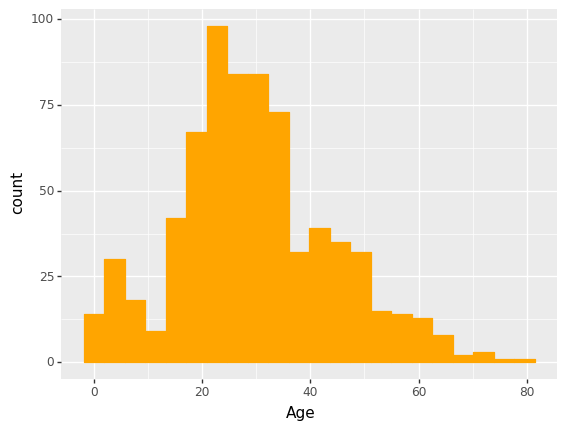


plot_mean_outcome_by_quantile


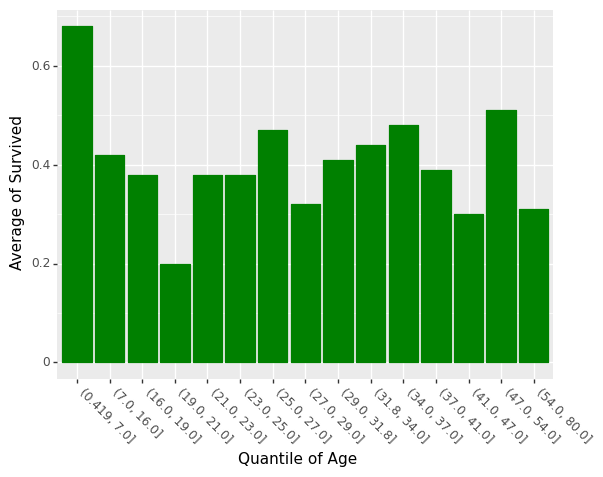


plot_outcome_counts


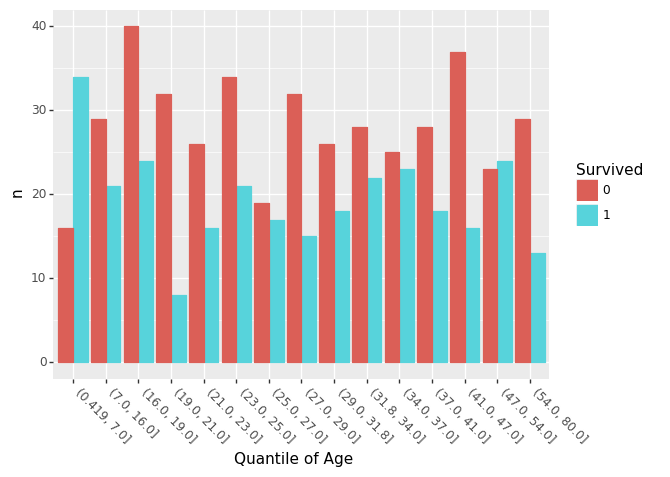

In [9]:
eda_age = summarise_continuous_feature(df_input = data, column = 'Age', outcome = 'Survived', n_quantiles = 15)

for (key, value) in eda_age.items():
    print(key)
    print(value)

mean_outcome_by_quantile
            quantile    n  avg_outcome
0     (-0.001, 7.55]   92         0.14
1      (7.55, 7.854]   87         0.30
2      (7.854, 8.05]  106         0.18
3       (8.05, 10.5]   78         0.23
4     (10.5, 14.454]   84         0.43
5   (14.454, 21.679]   88         0.42
6     (21.679, 27.0]   89         0.52
7     (27.0, 39.688]   91         0.37
8   (39.688, 77.958]   89         0.53
9  (77.958, 512.329]   87         0.76
outcome_count_by_quantile
             quantile Survived   n
0      (-0.001, 7.55]        0  79
1      (-0.001, 7.55]        1  13
2       (7.55, 7.854]        0  61
3       (7.55, 7.854]        1  26
4       (7.854, 8.05]        0  87
5       (7.854, 8.05]        1  19
6        (8.05, 10.5]        0  60
7        (8.05, 10.5]        1  18
8      (10.5, 14.454]        0  48
9      (10.5, 14.454]        1  36
10   (14.454, 21.679]        0  51
11   (14.454, 21.679]        1  37
12     (21.679, 27.0]        0  43
13     (21.679, 27.0]        1

/Users/sid_basu/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 107'. Pick better value with 'binwidth'.


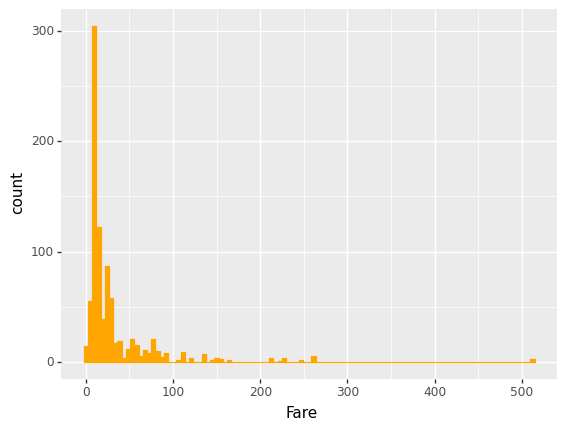


plot_mean_outcome_by_quantile


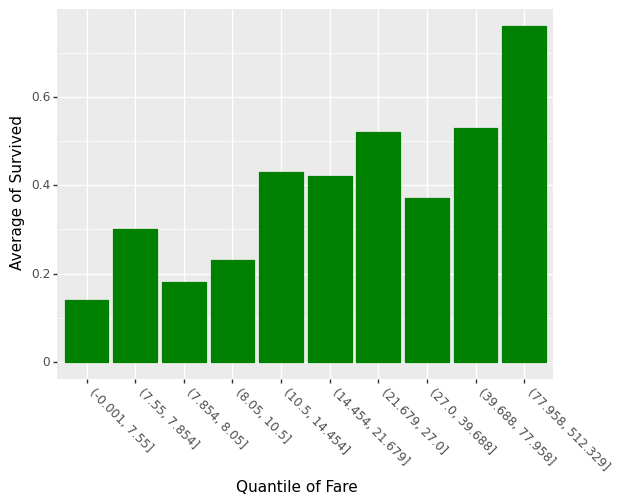


plot_outcome_counts


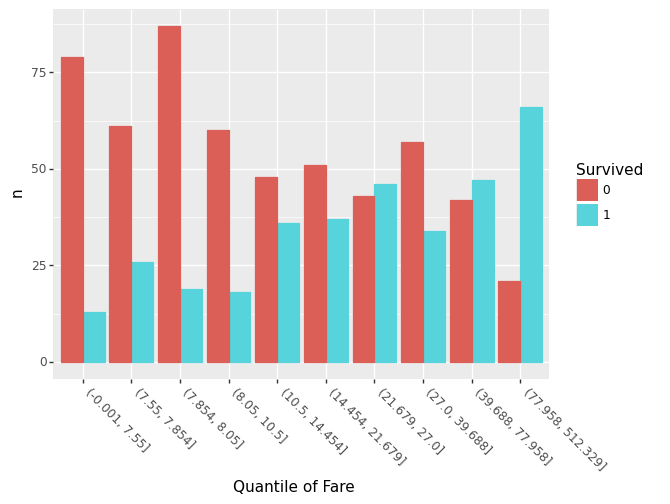

In [10]:
eda_fare = summarise_continuous_feature(df_input = data, column = 'Fare', outcome = 'Survived', n_quantiles = 10)

for (key, value) in eda_fare.items():
    print(key)
    print(value)

# Plot a histogram of every column because why not

/Users/sid_basu/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 22'. Pick better value with 'binwidth'.
/Users/sid_basu/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin : Removed 177 rows containing non-finite values.


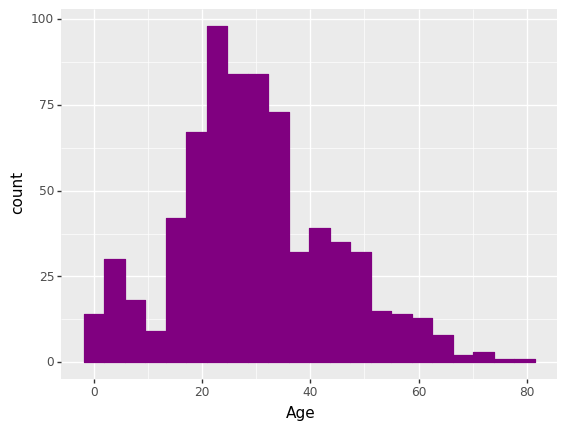

/Users/sid_basu/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 39'. Pick better value with 'binwidth'.


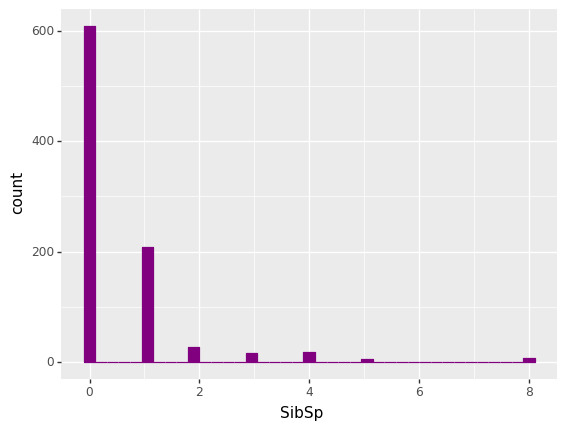

/Users/sid_basu/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 30'. Pick better value with 'binwidth'.


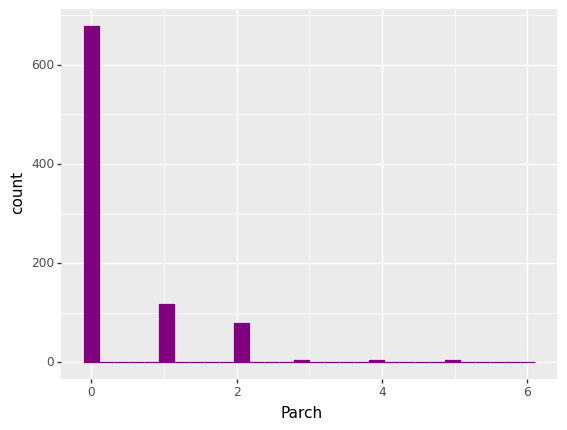

/Users/sid_basu/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 107'. Pick better value with 'binwidth'.


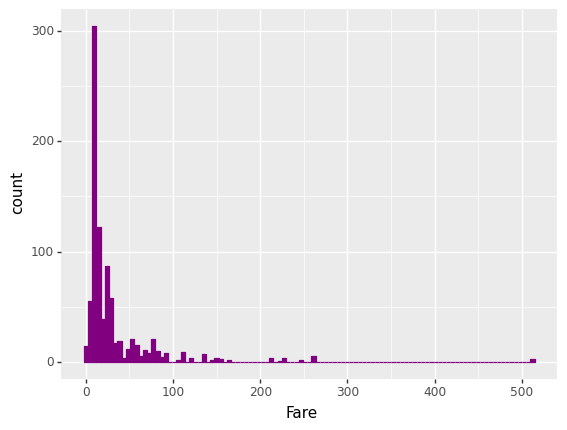

/Users/sid_basu/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 10'. Pick better value with 'binwidth'.


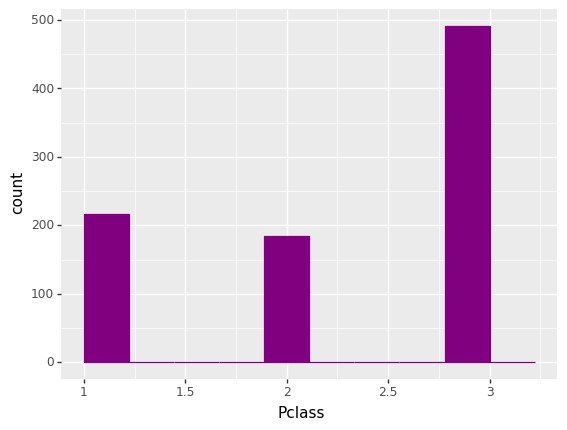

/Users/sid_basu/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 5'. Pick better value with 'binwidth'.


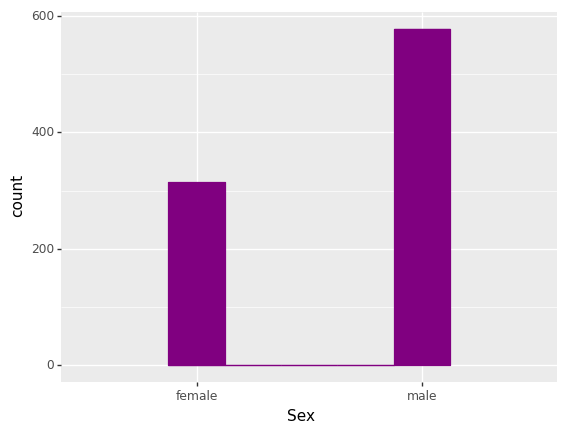

/Users/sid_basu/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 15'. Pick better value with 'binwidth'.


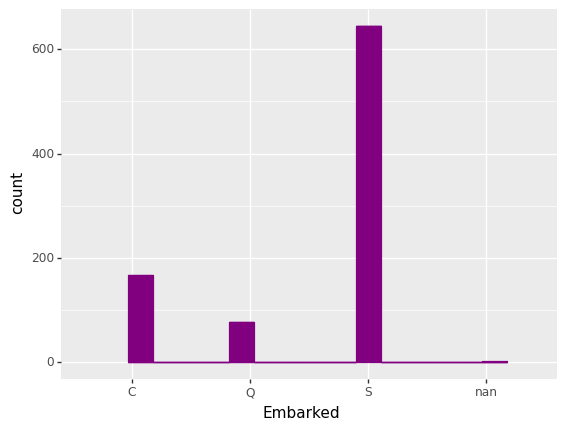

In [11]:
for column in numeric_cols + categorical_cols:
    x = (
        ggplot(data, aes(x = column)) + 
        geom_histogram(color = 'purple', fill = 'purple')
    )

    print(x)

# Look at patterns of `Nan`s and devise an imputation strategy

In [12]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
quantile         0
dtype: int64

## Dealing with NA's in Age

In [13]:
data['Age_na'] = data['Age'].isna().astype(int)

#compute the fraction of people with missing age in each categorical column
for column in categorical_cols:
    print(data.groupby(column).agg(frac_missing = ('Age_na', 'mean')).reset_index().round(2))

   Pclass  frac_missing
0       1          0.14
1       2          0.06
2       3          0.28
      Sex  frac_missing
0  female          0.17
1    male          0.21
  Embarked  frac_missing
0        C          0.23
1        Q          0.64
2        S          0.14


In [14]:
#grouping by Age_na, see what categorical column distributions look like
for column in categorical_cols:
    print(data.groupby('Age_na')[column].value_counts(normalize=True))

Age_na  Pclass
0       3         0.497199
        1         0.260504
        2         0.242297
1       3         0.768362
        1         0.169492
        2         0.062147
Name: Pclass, dtype: float64
Age_na  Sex   
0       male      0.634454
        female    0.365546
1       male      0.700565
        female    0.299435
Name: Sex, dtype: float64
Age_na  Embarked
0       S           0.778090
        C           0.182584
        Q           0.039326
1       S           0.508475
        Q           0.276836
        C           0.214689
Name: Embarked, dtype: float64


In [15]:
# Filling the missing values in Age with the medians of Sex and Pclass groups

def impute_medians(df_input, target_col = 'Age', grouping_cols = ['Sex', 'Pclass']):

    group_medians = df_input.groupby(grouping_cols).agg(median = (target_col, 'median')).reset_index()
    df_return = df_input.merge(group_medians, on = grouping_cols)
    df_return.loc[df_return[target_col].isna(), target_col] = df_return['median']
    return(df_return)

#impute_medians(data, target_col='Age', grouping_cols=['Sex', 'Pclass'])


In [16]:
from sklearn.model_selection import train_test_split
X, y = data[numeric_cols + categorical_cols].copy(), np.asarray(data[target], dtype='int8')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20230116)

In [17]:
from sklearn.preprocessing import FunctionTransformer

transformer = FunctionTransformer(impute_medians)
transformer.fit_transform(X_train)[:10]

,Age,SibSp,Parch,Fare,Pclass,Sex,Embarked,median
0,26.0,1,0,7.8542,3,male,S,26.0
1,4.0,1,1,11.1333,3,male,S,26.0
2,47.0,0,0,9.0000,3,male,S,26.0
3,22.0,0,0,7.2250,3,male,C,26.0
4,19.0,0,0,7.6500,3,male,S,26.0
5,26.0,0,0,7.2500,3,male,S,26.0
6,45.0,0,0,8.0500,3,male,S,26.0
7,28.0,1,0,15.8500,3,male,S,26.0
8,19.0,0,0,8.0500,3,male,S,26.0
9,26.0,0,0,7.0500,3,male,S,26.0


In [18]:
transformer.transform(X_test)[:100]

,Age,SibSp,Parch,Fare,Pclass,Sex,Embarked,median
0,36.0,0,0,26.2875,1,male,S,37.5
1,47.0,0,0,52.0000,1,male,S,37.5
2,38.0,1,0,90.0000,1,male,S,37.5
3,31.0,1,0,52.0000,1,male,S,37.5
4,62.0,0,0,26.5500,1,male,S,37.5
...,...,...,...,...,...,...,...,...
95,18.0,0,0,7.7500,3,male,S,24.0
96,24.0,0,0,7.7500,3,male,Q,24.0
97,32.0,0,0,8.0500,3,male,S,24.0
98,24.0,0,0,7.7500,3,male,Q,24.0


In [19]:
from sklearn.impute import KNNImputer

#when given a single column, this imputer simply fills na's with the mean of the column
imputer = KNNImputer(n_neighbors = 3)
X, y = data[numeric_cols + categorical_cols].copy(), np.asarray(data[target], dtype='int8')
imputer.fit_transform(X[['Age']])[:10]


array([[22.        ],
       [38.        ],
       [26.        ],
       [35.        ],
       [35.        ],
       [29.69911765],
       [54.        ],
       [ 2.        ],
       [27.        ],
       [14.        ]])

In [20]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(initial_strategy='median', skip_complete = True)
imputer.fit_transform(X[numeric_cols])

array([[22.        ,  1.        ,  0.        ,  7.25      ],
       [38.        ,  1.        ,  0.        , 71.2833    ],
       [26.        ,  0.        ,  0.        ,  7.925     ],
       ...,
       [24.17134966,  1.        ,  2.        , 23.45      ],
       [26.        ,  0.        ,  0.        , 30.        ],
       [32.        ,  0.        ,  0.        ,  7.75      ]])

# Train model with user-defined imputation and feature selector

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        return X.loc[:, self.feature_names].copy(deep = True)

In [22]:
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [23]:
class TestImputer(BaseEstimator, TransformerMixin):
    def __init__(self, target_col, grouping_cols):
        self.target_col = target_col
        self.grouping_cols = grouping_cols

    def fit(self, X, y = None):
        self.group_medians = X.groupby(self.grouping_cols).agg(median = (self.target_col, 'median')).reset_index()
        print(self.group_medians)
        return self

    def transform(self, X, y = None):
        df_return = X.merge(self.group_medians, on = self.grouping_cols)
        #df_return.loc[df_return[self.target_col].isna(), self.target_col] = df_return['median']
        return df_return

In [65]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
#from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
import xgboost as xgb
from sklearn import set_config
set_config(display='diagram')

target = 'Survived'
numeric_cols = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_cols = ['Pclass', 'Sex', 'Embarked']

X, y = data[numeric_cols + categorical_cols].copy(), np.asarray(data[target], dtype = 'int8')
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 20230216)
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20230118)

categorical_pipeline = Pipeline(steps = [
    ("selector", FeatureSelector(categorical_cols)),
    ("encoder", OneHotEncoder(handle_unknown='ignore')),
])

numerical_pipeline = Pipeline(steps = [
    ('selector', FeatureSelector(numeric_cols)),
    ('scaler', StandardScaler()),
])

feature_pipeline = FeatureUnion(
    transformer_list = [
    ("numerical_pipeline", numerical_pipeline),
    ("categorical_pipeline", categorical_pipeline),
    ]
)

xgb_model = xgb.XGBClassifier(eval_metric = 'logloss')

model_pipeline = Pipeline(
    steps = [
    ("feature_pipeline", feature_pipeline),
    ('to_dense', DenseTransformer()),
    ('imputer', IterativeImputer()),                               
    ("model", xgb_model)
    ]
)

#Historical code for future reference
#model_pipeline.fit(X_train, y_train)
#preds = model_pipeline.predict_proba(X_test)[:,1]
#preds_binary = model_pipeline.predict(X_test)

#scores_list, cm, plots_list = model_diagnostics(y_test = y_test, preds = preds, preds_binary = preds_binary)

In [67]:
cv_results = cross_validate(model_pipeline, X, y, cv = skf, scoring = 'accuracy', return_estimator = True)

preds_list, preds_binary_list, y_list = skf_preds(skf = skf, X = X, y = y, estimators = cv_results['estimator'])

/Users/sid_basu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
/Users/sid_basu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
/Users/sid_basu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
/Users/sid_basu/opt/anaconda3/lib/python

In [68]:
df_scores, df_scores_agg, cm_display, plots_list = model_diagnostics_skf(preds_list, preds_binary_list, y_list)

In [69]:
df_scores_agg

accuracy             0.820362
average_precision    0.844154
f1_score             0.764154
auc                  0.862415
dtype: float64

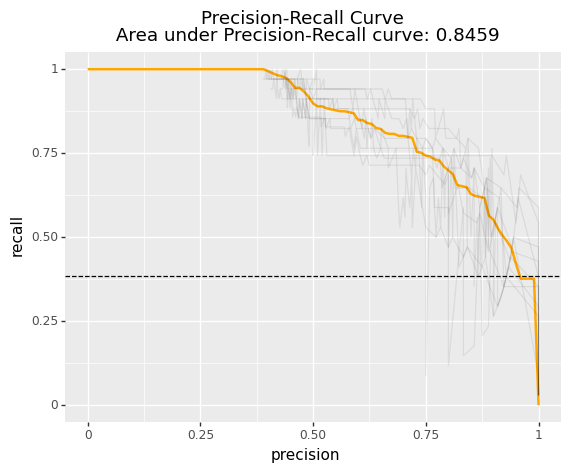

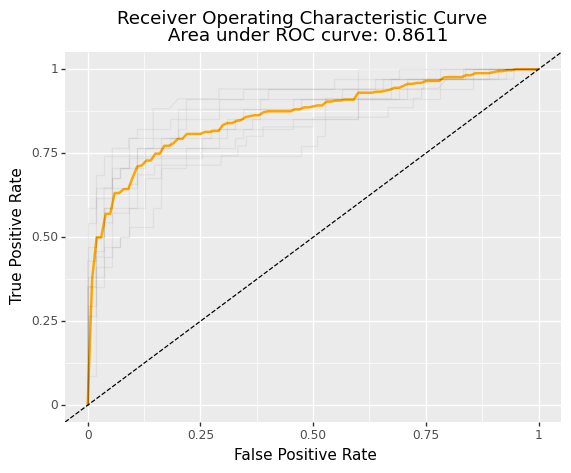

[<ggplot: (8787124989073)>, <ggplot: (8787121167180)>]

In [70]:
plots_list

# Train model with ColumnTransformer and IterativeImputer

In [62]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
import xgboost as xgb

target = 'Survived'
numeric_cols = ['SibSp', 'Parch', 'Fare', 'Age']
categorical_cols = ['Pclass', 'Sex', 'Embarked']

X, y = data[numeric_cols + categorical_cols].copy(), np.asarray(data[target], dtype = 'int8')
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 20230205)
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20230118)


ct_encode = ColumnTransformer([
#    ('scaler', StandardScaler(), numeric_cols), #if just this line, the pipeline will only return the four numeric columns, scaled
    ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical_cols), #this line adds dummies for class (3 values), sex (2 values) and embarked (4 values)
    ('pass_through_numerics', 'passthrough', numeric_cols)
])

ct_disc = ColumnTransformer(
    transformers = [('disc_age', KBinsDiscretizer(n_bins = 10, encode = 'ordinal'), [-1]),
                    ('disc_fare', KBinsDiscretizer(n_bins = 15, encode = 'ordinal'), [-2])],
    remainder = 'passthrough'
)

ct_scale = ColumnTransformer(
    transformers = [('scale', StandardScaler(), [-1, -2])],
    remainder = 'passthrough'
)

xgb_model = xgb.XGBClassifier(eval_metric = 'logloss')

pipe = Pipeline([
    ('encode_cats', ct_encode),
    ('imputer', IterativeImputer()),
    ('discretize', ct_disc),
    ('clf', xgb_model),
])

#pipe.fit(X_train, y_train)

In [46]:
cv_results = cross_validate(pipe, X, y, cv = skf, scoring = 'accuracy', return_estimator = True)

preds_list, preds_binary_list, y_list = skf_preds(skf = skf, X = X, y = y, estimators = cv_results['estimator'])

In [59]:
df_scores, df_scores_agg, cm_display, plots_list = model_diagnostics_skf(preds_list, preds_binary_list, y_list)

In [60]:
df_scores_agg

accuracy             0.806941
average_precision    0.832538
f1_score             0.739679
auc                  0.863718
dtype: float64

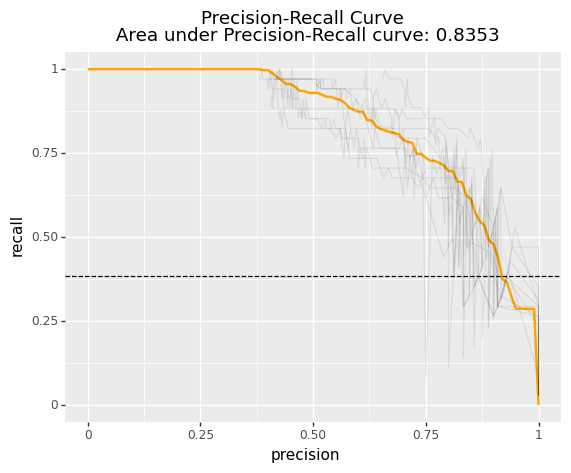

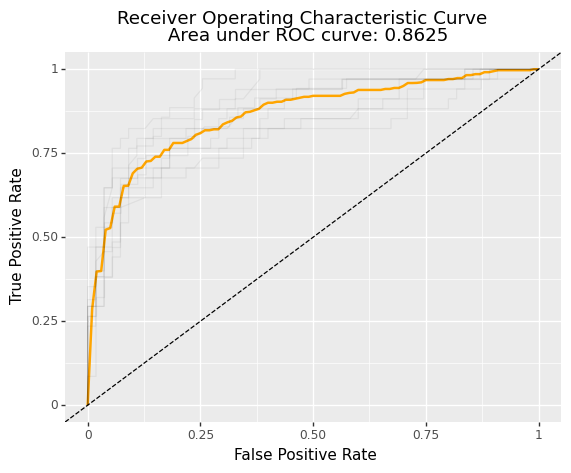

[<ggplot: (8787121013523)>, <ggplot: (8787120188109)>]

In [61]:
plots_list

# Extra code

In [38]:
# preds = pipe.predict_proba(X_test)[:,1]
# preds_binary = pipe.predict(X_test)

# scores_list, cm, plots_list = model_diagnostics(y_test = y_test, preds = preds, preds_binary = preds_binary)